## Acquire images

This notebook will:

* Section 1: For a given bounding box and year, find all SAR images in that region. Get some stats on them
* Section 2: Filter out images from scenes that don't have sufficient preceding winter imagery for melt detection
* Section 3: Run ASF Hyp3 RTC processing
* Section 4: Download the data. Reproject it immedately and save only the smaller image. Does that work? I thought I would have to have EPSG vals? This will have to get figured out

### Preamble
Prepare to do stuff

In [21]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time
import fnmatch

from matplotlib import pyplot as plt
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [17]:
##NAME PROJECT###
projdir = Path.home()/"GlacierSARdata"
projname = 'Bagley'
year = 2018
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

print(download_path)
print(products_path)
print(clipped_path)

os.makedirs(data_dir,exist_ok=True)
os.makedirs(download_path,exist_ok=True)
os.makedirs(products_path,exist_ok=True)
os.makedirs(analysis_directory/"figures",exist_ok=True)
os.makedirs(clipped_path,exist_ok=True)
for pol in pols:
    os.makedirs(clipped_path/pol,exist_ok=True)

# print(os.path.exists(data_dir))

WTKstr = None
if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau
if projname=="Bagley": WTKstr='POLYGON((-140.9179 59.7892,-138.4877 59.7892,-138.4877 60.8884,-140.9179 60.8884,-140.9179 59.7892))' #Bagley

analysis_directory: /home/jovyan/GlacierSARdata/Bagley/2018
/home/jovyan/GlacierSARdata/Bagley/2018/rtc_download
/home/jovyan/GlacierSARdata/Bagley/2018/rtc_products
/home/jovyan/GlacierSARdata/Bagley/2018/rtc_clipped


In [3]:
# def timediff(time1,time2,form='seconds'):
#     '''time difference between time2 and time1 expressed as either days or seconds'''
#     # dd = 1
#     # if time1>time2:
#     #     dd=1
#     diff = time2-time1
#     if form=='seconds':
#         diff = diff.seconds+diff.days*86400
#     elif form=='days':
#         diff = diff.seconds/86400+diff.days
#     return diff

## Find SAR Images

Find the SAR images, run some statistics on their frequency, and queue them for Hyp3 processing

* stuff
* other stuff

In [17]:
# WTKstr = None
# if projname=="Wrangell": WTKstr='POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Mt Wrangell
# if projname=="Denali_h": WTKstr='POLYGON((-151.6946 62.7583,-150.1696 62.7583,-150.1696 63.2668,-151.6946 63.2668,-151.6946 62.7583))' #Denali_h (mostly higher elevations)
# if projname=="Harding": WTKstr='POLYGON((-150.6448 59.6467,-149.5491 59.6467,-149.5491 60.2703,-150.6448 60.2703,-150.6448 59.6467))' #Harding
# if projname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

#testpolygon = POLYGON((-143.1356 61.7756,-143.3698 61.7793,-143.5279 61.7044,-143.3824 61.6052,-143.0614 61.4737,-142.9854 61.4144,-142.804 61.4292,-142.7358 61.5912,-142.5978 61.6494,-142.6707 61.7523,-142.9699 61.7839,-143.1356 61.7756))
# WTKstr='POLYGON((-143.4858 61.4239,-142.5307 61.4239,-142.5307 61.7757,-143.4858 61.7757,-143.4858 61.4239))' #Kennicott
# testWTK='POLYGON((-134.5463 58.5889,-133.8663 58.5889,-133.8663 58.7656,-134.5463 58.7656,-134.5463 58.5889))' #SE AK icefield
# testWTK='POLYGON((-18.2664 63.9706,-15.2442 63.9706,-15.2442 64.9461,-18.2664 64.9461,-18.2664 63.9706))' #iceland
# testWTK='POLYGON((15.123 78.0197,16.9688 78.0197,16.9688 78.2449,15.123 78.2449,15.123 78.0197))' #svalbard
# testWTK = 'POLYGON((-140.264 60.3786,-140.0853 60.3786,-140.0853 60.4539,-140.264 60.4539,-140.264 60.3786))'
# testWTK='POLYGON((-50.0733 70.6347,-47.6859 70.6347,-47.6859 71.1109,-50.0733 71.1109,-50.0733 70.6347))' #west greenland

In [3]:
#funcs for this kind of thing:

def timediff(time1,time2,form='seconds'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def getasfresults(WTKstr,year,trimresults=True,winterN=4,showplots=False,showstats=False):
    """trim results removes images if there are less than winterN number of winter scenes to establish the baseline"""
    results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], intersectsWith=WTKstr, maxResults=1000,start=f'{str(year)}-01-01',
                         end=f'{str(year+1)}-01-01',processingLevel='SLC')

    datelist = []
    pflist = [] #path-frame list
    for res in results:
        res = res.properties
        # print(res['startTime'])
        rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
        rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
        # print(rdate)
        res['datetime']=rdate
        res['pfval'] = rpf
        datelist.append(rdate)
        pflist.append(rpf)


    pfunique = np.unique(pflist)
    pfvals = pflist
    pflist = [np.where(pfunique==i)[0][0] for i in pflist]
    
    if showplots==True:
        plt.figure()
        plt.plot(datelist,pflist,'.',markersize=12)
        
    if trimresults==True:
        wstart = datetime(year,1,1,0,0,0)
        wend = datetime(year,4,1,1,0,0,0)
        #result2 = results
        pfremove=[]
        trem = 0
        #identify path-frames that do not meet requirements
        for pf in pfunique:
            eles = [i for i in results if i.properties['pfval']==pf]
            datelist = np.array([i.properties['datetime'] for i in eles])
            dl2 = datelist[datelist > wstart]
            dl2 = dl2[dl2 < wend]
            if len(dl2)<winterN:
                pfremove.append(pf)
                trem += len(datelist)

        #remove images from those path-frames
        for res in results:
            if res.properties['pfval'] in pfremove:
                results.remove(res)

        print(f'total removed: {trem}')
        # print(pfremove)
        
        #now plot again:
        datelist = [i.properties['datetime'] for i in results]
        pflist = [i.properties['pfval'] for i in results]
        pfunique = np.unique(pflist)
        pflist = [np.where(pfunique==i)[0][0] for i in pflist]

        if showplots==True:
            plt.figure()
            plt.plot(datelist,pflist,'.',markersize=12)
        
    if showstats==True:
        dlsort = [i for i in datelist]
        dlsort.sort()
        dldelta = [timediff(dlsort[i],dlsort[i+1],form='days') for i in range(len(dlsort)-1)]
        dldelta = np.array(dldelta)

        print('Acquisition stats')
        print(f'Number of acquisitions:       {len(dldelta)+1}')
        print(f'Number of images >1min apart: {len(dldelta[dldelta>1/1440])+1}\n')
        print(f'Mean days apart:   {np.mean(dldelta):.3f}')
        print(f'Mean days >1min:   {np.mean(dldelta[dldelta>1/1440]):.3f}')
        print(f'Median days apart: {np.median(dldelta):.3f}')
        print(f'Median days >1min: {np.median(dldelta[dldelta>1/1440]):.3f}')
        print(f'Stdev days apart:  {np.std(dldelta):.3f}')
        print(f'Longest gap:       {np.max(dldelta):.3f}')
        print('Note: these are over the whole area, not necessarily by pixel')
        
    return results

## Do Hyp3 Processing

I need to:

1. Identify all the images you want DONE
2. Check if any of those are already RTC processed (not expired)
3. Process all the remaining jobs
4. Make a hyp3 object for the full list of jobs, with those done via new process and those done via old process
5. download, extract, convert, and clip from those jobs

In [4]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  acjohnson16
NASA Earthdata Login password:  ········


In [5]:
readyproducts = hyp3.find_jobs()
print(readyproducts)

4463 HyP3 Jobs: 4462 succeeded, 1 failed, 0 running, 0 pending.


Bagley: 2018


/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


total removed: 0
Acquisition stats
Number of acquisitions:       182
Number of images >1min apart: 106

Mean days apart:   1.989
Mean days >1min:   3.428
Median days apart: 0.525
Median days >1min: 4.012
Stdev days apart:  2.498
Longest gap:       7.988
Note: these are over the whole area, not necessarily by pixel
total removed: 0
jobs already ready: 182
Number of jobs to do: 0


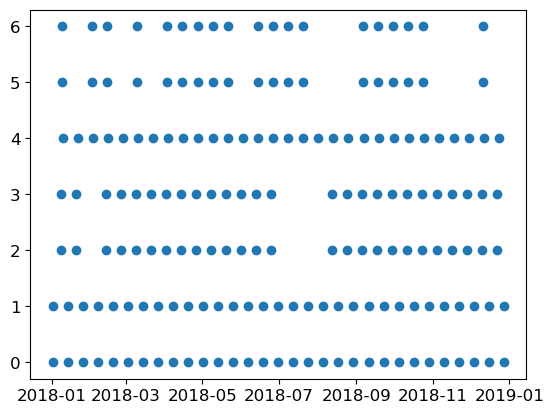

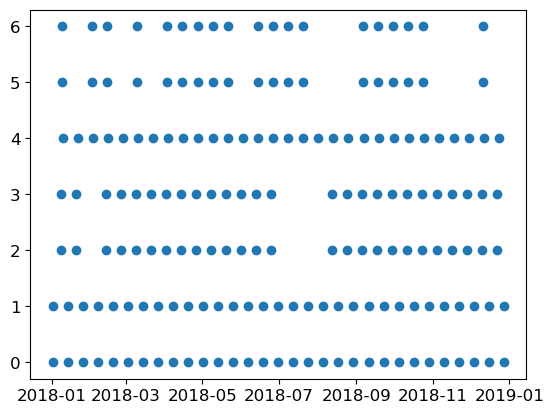

In [18]:
#Get_Data

print(f'{projname}: {year}')
readyproducts = hyp3.find_jobs()
readyproducts = readyproducts.filter_jobs(succeeded=True,include_expired=False)
readyprodnames = [i.job_parameters['granules'][0] for i in readyproducts]

results = getasfresults(WTKstr,year,showplots=True,showstats=True)
dojobs = getasfresults(WTKstr,year)
resultnames = [i.properties['sceneName'] for i in results]

remcount = 0
for i,job in enumerate(results):
    jobscene = job.properties['sceneName']
    dojobnames = np.array([i.properties['sceneName'] for i in dojobs])
    job = dojobs[np.where(dojobnames==jobscene)[0][0]]
    # othercount += 1
    if job.properties['sceneName'] in readyprodnames:
        # print(i)
        dojobs.remove(job)
        remcount += 1
        

print(f'jobs already ready: {remcount}')
print(f'Number of jobs to do: {len(dojobs)}')

In [30]:
#Submit jobs for RTC processing

projectname = f'{projname}_{year%1000}'

granules = [i.properties['sceneName'] for i in dojobs]

submitjobs = True
if submitjobs:
    rtc_jobs = Batch()
    for g in granules:
        rtc_jobs += hyp3.submit_rtc_job(g, name=projectname)
    print(rtc_jobs)
else:
    print("Note: no job submitted as submitjobs is currently 'False'")
print(hyp3.my_info()['quota'])

182 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 182 pending.
{'max_jobs_per_month': 1000, 'remaining': 202}


In [29]:
# print(hyp3.my_info()['quota'])

{'max_jobs_per_month': 1000, 'remaining': 384}


In [16]:
#do failed jobs if necessary (set to True)

dofailedjob = False
if dofailedjob:
    hyp3.submit_rtc_job('S1A_IW_SLC__1SDV_20210701T155634_20210701T155701_038586_048D97_C318', name = projectname)

In [8]:
print(hyp3.my_info()['quota'])

{'max_jobs_per_month': 1000, 'remaining': 742}


## Utility Functions

download images\
extract images\
reproject and clip to wtk\
convert to db\
do this sequentially

In [7]:
#convert utility
def converttodb(file):
    ds = gdal.Open(file, gdal.GA_Update)
    data = ds.ReadAsArray()

    data[data<1e-6]=1e-6
    
    data = 10*np.log10(data)
    data[data==-np.inf]=-60
    ds.GetRasterBand(1).WriteArray(data)
    ds = None

#download utility:
def extracttif(inloc,outloc,pol='VV',convert=True):
    """expect pol to be 'VV','VH','HH', or 'HV' 
    convert will convert this to db"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infile = glob.glob(f'{inloc}*')
    endstr = pol+'.tif'
    for file in infile:
        # print(file)
        # namelist = 
        with ZipFile(file) as z:
            # print(z.namelist)
            z = ZipFile(file)
            zname = [name for name in z.namelist() if name[-6:]==endstr]
            if len(zname)>0:
                zname = zname[0]
        
                filename = os.path.basename(zname)
                source = z.open(zname)
                targetname = os.path.join(outloc, filename)
                target = open(targetname, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)
                target.close()
                if convert:
                    converttodb(targetname)
        # os.remove(file)
        

In [8]:
#CLIPPING TOOLS

def wtkparse(wtk):
    """It's not weird if it works"""
    wtk = wtk.split("'")
    wtk = wtk[0].split("(")[2]
    wtk = wtk.split(")")[0]
    wtk = wtk.split(',')
    wtk = [s.split(' ') for s in wtk]
    wtk = np.array([[float(ss) for ss in s] for s in wtk])
    return(wtk)

def CoordConvert(points,inproj,outproj,ptparse=False):
    """Convert coordinate grid from one projection to another
    if converting from 4326, then points should be ordered lon,lat"""

    if ptparse:
        points = wtkparse(points)

    if type(inproj)==str:
        inproj=int(inproj)
    if type(outproj)==str:
        outproj=int(outproj)

    epsgin = osr.SpatialReference()
    epsgin.ImportFromEPSG(inproj)   
    epsgout = osr.SpatialReference()
    epsgout.ImportFromEPSG(outproj)

    convert = osr.CoordinateTransformation(epsgin, epsgout)
    points = np.array(points)
    
    for i,x in enumerate(points):
        newpt = convert.TransformPoint(x[1],x[0])
        points[i,0],points[i,1]=newpt[0],newpt[1]
        
    return points

def wtktobox(wtk,epsgn,srcproj = 4326):
    """epsgn is the epsg of the tif file
    output will be ulx uly lrx lry"""
    epsgn = int(epsgn)
    srcproj = int(srcproj)
    xyp = CoordConvert(wtk,4326,epsgn,ptparse=True)
    ulx,uly = np.min(xyp[:,0]),np.max(xyp[:,1])
    lrx,lry = np.max(xyp[:,0]),np.min(xyp[:,1])
    return ulx,uly,lrx,lry

def testEPSG(inloc):
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    # if str(outloc)[-1]!='/':
        # outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    for file in infiles:
        ds=gdal.Open(file)
        proj = osr.SpatialReference(wkt=ds.GetProjection())
        dsproj = proj.GetAttrValue('AUTHORITY',1)
        ds = None
        print(dsproj)
# testEPSG(products_path)

def getEPSG(file):
    ds=gdal.Open(file)
    proj = osr.SpatialReference(wkt=ds.GetProjection())
    dsproj = proj.GetAttrValue('AUTHORITY',1)
    ds = None
    return dsproj

def identify_epsgs(fileloc):
    """Identify EPSG systems used in this. By default this will return the most commonly one."""
    if str(fileloc)[-1]!='/':
        fileloc = str(fileloc)+'/'
    filelist = glob.glob(f'{fileloc}*')
    eplist = []
    for file in filelist:
        eplist.append(getEPSG(file))
        # print(eplist[-1])
        # print(file)
    epu,epc = np.unique(eplist,return_counts=True)
    for i,ep in enumerate(epu):
        count = epc[i]
        print(f'Found EPSG:{ep}, count: {count}')
    return epu[np.where(epc==np.max(epc))[0]][0]

def reproject(wtk,epsgn,inloc,outloc,res=30,convert_to_db=False):
    """make the magic happen"""
    if str(inloc)[-1]!='/':
        inloc = str(inloc)+'/'
    if str(outloc)[-1]!='/':
        outloc = str(outloc)+'/'
    infiles = glob.glob(f'{inloc}*')
    
    epsgn = int(epsgn)
    ulx,uly,lrx,lry = wtktobox(wtk,epsgn)
    # c1=0
    epsgns = f'ESPG:{str(epsgn)}'
    for file in infiles:
        ofile = file.replace(inloc,outloc)
        # ofile = '/home/jovyan/test/rtc_clipped/S1B_IW_20210713T031944_DVP_RTC30_G_gpuned_1E76_VV'
        epsgf = int(getEPSG(file))
        epsgfs = f'ESPG:{str(epsgf)}'
        src = gdal.Open(file)
        # print(ofile)
        # print(type(ofile))
        
        epsgo = osr.SpatialReference()
        epsgo.ImportFromEPSG(epsgn)   
        
        gdal.Warp(destNameOrDestDS=ofile,srcDSOrSrcDSTab=src,dstSRS=epsgo,
                  outputBounds=(ulx,lry,lrx,uly),outputBoundsSRS=epsgo,resampleAlg='near',
                  xRes=res,yRes=res)
        
        if convert_to_db:
            converttodb(ofile)

## Get Data

In [13]:
#Download the products, unzip them into the rtc_download directory, convert them to dB, and delete the zip files:

# EPSGn = '32607'
pols = ['VV','VH']

autoEPSG=True #use this to pull the first projection and use that as your projection for all images

# First check if jobs are running
class Error(Exception):
    """Base class for other exceptions"""
    pass
class stillrunningError(Error):
    """raised when jobs are still running"""
    pass

running = len(hyp3.find_jobs(status_code=["RUNNING"]))
running += len(hyp3.find_jobs(status_code=["PENDING"]))

if running > 0:
    print('Jobs still running!')
    raise stillrunningError
else:
    print('No jobs running, all clear')

No jobs running, all clear


In [19]:
# Get the list of jobs to download
usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
joblen = len(results)-1

t = time.time()
count = 0
for i,job in enumerate(joblist):

    jobname = job.job_parameters['granules'][0]

    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        # job.download_files(download_path)
        # for pol in pols:
            # print(pol)
            # extracttif(download_path,products_path,pol=pol,convert=False)
            # if autoEPSG:
                # if (count == 1) and (pol == pols[0]):
                    # fileg = glob.glob(f'{str(products_path)}/*.tif')
                    # EPSGn = getEPSG(fileg[0])
                    # print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            # reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            # os.system(f'rm {str(products_path)}/*.tif')
            # time.sleep(3)
        # os.system(f'rm {str(download_path)}/*.zip')
        print(f"{i}: {jobname}")
print(count)
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

15: S1A_IW_SLC__1SDV_20180101T154753_20180101T154820_019963_021FF5_D8E9
16: S1A_IW_SLC__1SDV_20180101T154818_20180101T154844_019963_021FF5_E900
17: S1B_IW_SLC__1SDV_20180108T030209_20180108T030239_009074_010389_5DBA
18: S1B_IW_SLC__1SDV_20180108T030237_20180108T030305_009074_010389_45C7
19: S1A_IW_SLC__1SDV_20180109T025443_20180109T025510_020072_02235C_D1EC
20: S1B_IW_SLC__1SDV_20180109T153113_20180109T153141_009096_01044E_992E
21: S1A_IW_SLC__1SDV_20180109T025508_20180109T025535_020072_02235C_AC35
22: S1A_IW_SLC__1SDV_20180113T154752_20180113T154819_020138_02257E_84D0
23: S1A_IW_SLC__1SDV_20180113T154817_20180113T154843_020138_02257E_4771
Current job: 10/181, time elapsed: 0.00 min, time remaining: 0.00 min
24: S1B_IW_SLC__1SDV_20180120T030236_20180120T030304_009249_01093F_CFAE
25: S1B_IW_SLC__1SDV_20180120T030209_20180120T030239_009249_01093F_4718
26: S1B_IW_SLC__1SDV_20180121T153112_20180121T153140_009271_010A01_619F
27: S1A_IW_SLC__1SDV_20180125T154752_20180125T154819_020313_022B0A

In [85]:
usegranules = [i.properties['sceneName'] for i in results]
# joblist = hyp3.find_jobs()
# joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
# joblen = len(results)-1

#NOTE: a result that is listed by has no file is: 1201T...22
#      a file that exists by has no result is:    

job = joblist[-11]
jobname = job.job_parameters['granules']
print(jobname)
# job.download_files(download_path)
# reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
# os.system(f'rm {str(products_path)}/*.tif')
# os.system(f'rm {str(download_path)}/*.zip')
for i,job in enumerate(joblist):
    print(f'{i}: {job.job_parameters["granules"][0]}')

['S1B_IW_SLC__1SDV_20171203T030304_20171203T030331_008549_00F2AE_DE90']
0: S1B_IW_SLC__1SSV_20170101T162824_20170101T162901_003657_006459_DCFF
1: S1B_IW_SLC__1SSV_20170103T161202_20170103T161230_003686_00653D_E5A4
2: S1B_IW_SLC__1SSV_20170103T161228_20170103T161256_003686_00653D_BACD
3: S1B_IW_SLC__1SSV_20170125T162823_20170125T162900_004007_006EB3_A47A
4: S1B_IW_SLC__1SSV_20170127T161202_20170127T161229_004036_006F95_CAFC
5: S1B_IW_SLC__1SSV_20170127T161227_20170127T161255_004036_006F95_EFFE
6: S1B_IW_SLC__1SSV_20170218T162823_20170218T162900_004357_007925_1CB7
7: S1B_IW_SLC__1SSV_20170220T161201_20170220T161228_004386_007A0B_760E
8: S1B_IW_SLC__1SSV_20170220T161226_20170220T161255_004386_007A0B_9CB5
9: S1B_IW_SLC__1SSV_20170304T161201_20170304T161229_004561_007F26_19EF
10: S1B_IW_SLC__1SSV_20170314T162823_20170314T162900_004707_008371_4FCA
11: S1B_IW_SLC__1SSV_20170304T161227_20170304T161255_004561_007F26_2E55
12: S1B_IW_SLC__1SSV_20170316T161201_20170316T161229_004736_008452_BE3C
13

In [20]:
# Get the list of jobs to download
usegranules = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)
joblen = len(results)-1

t = time.time()
count = 0
for i,job in enumerate(joblist):

    jobname = job.job_parameters['granules'][0]

    if jobname in usegranules:
        count += 1
        usegranules.remove(jobname)
        if count%10 ==0:
            te = time.time()-t
            print(f'Current job: {count}/{joblen}, time elapsed: {te/60:.2f} min, time remaining: {(te/(i+1)*(joblen-count))/60:.2f} min')
        job.download_files(download_path)
        for pol in pols:
            # print(pol)
            extracttif(download_path,products_path,pol=pol,convert=False)
            if autoEPSG:
                if (count == 1) and (pol == pols[0]):
                    fileg = glob.glob(f'{str(products_path)}/*.tif')
                    EPSGn = getEPSG(fileg[0])
                    print(getEPSG(fileg[0]))
            # fulltif = glob.glob(f'{str(products_path)}/*{pol}*')
            reproject(WTKstr,EPSGn,products_path,f'{str(clipped_path)}/{pol}',convert_to_db=True)
            os.system(f'rm {str(products_path)}/*.tif')
            time.sleep(3)
        os.system(f'rm {str(download_path)}/*.zip')
        
if len(usegranules)>0:
    print('WARNING: NOT ALL GRANULES USED')

S1A_IW_20180101T154753_DVP_RTC30_G_gpuned_5DE5.zip:   0%|          | 0/453400658 [00:00<?, ?it/s]

32607


S1A_IW_20180101T154818_DVP_RTC30_G_gpuned_0D01.zip:   0%|          | 0/436258496 [00:00<?, ?it/s]

S1B_IW_20180108T030209_DVP_RTC30_G_gpuned_A941.zip:   0%|          | 0/501278625 [00:00<?, ?it/s]

S1B_IW_20180108T030237_DVP_RTC30_G_gpuned_AFCC.zip:   0%|          | 0/472181423 [00:00<?, ?it/s]

S1A_IW_20180109T025443_DVP_RTC30_G_gpuned_1F6E.zip:   0%|          | 0/457374352 [00:00<?, ?it/s]

S1B_IW_20180109T153113_DVP_RTC30_G_gpuned_6BE6.zip:   0%|          | 0/472803421 [00:00<?, ?it/s]

S1A_IW_20180109T025508_DVP_RTC30_G_gpuned_DA54.zip:   0%|          | 0/451373355 [00:00<?, ?it/s]

S1A_IW_20180113T154752_DVP_RTC30_G_gpuned_096A.zip:   0%|          | 0/453535952 [00:00<?, ?it/s]

S1A_IW_20180113T154817_DVP_RTC30_G_gpuned_E716.zip:   0%|          | 0/436086149 [00:00<?, ?it/s]

Current job: 10/181, time elapsed: 3.24 min, time remaining: 22.19 min


S1B_IW_20180120T030236_DVP_RTC30_G_gpuned_5E28.zip:   0%|          | 0/472539067 [00:00<?, ?it/s]

S1B_IW_20180120T030209_DVP_RTC30_G_gpuned_3C8E.zip:   0%|          | 0/501103757 [00:00<?, ?it/s]

S1B_IW_20180121T153112_DVP_RTC30_G_gpuned_4A6F.zip:   0%|          | 0/472624571 [00:00<?, ?it/s]

S1A_IW_20180125T154752_DVP_RTC30_G_gpuned_9DFA.zip:   0%|          | 0/453753734 [00:00<?, ?it/s]

S1A_IW_20180125T154817_DVP_RTC30_G_gpuned_D55F.zip:   0%|          | 0/436354913 [00:00<?, ?it/s]

S1A_IW_20180202T025442_DVP_RTC30_G_gpuned_34A9.zip:   0%|          | 0/456049991 [00:00<?, ?it/s]

S1A_IW_20180202T025507_DVP_RTC30_G_gpuned_A37D.zip:   0%|          | 0/451747236 [00:00<?, ?it/s]

S1A_IW_20180206T154752_DVP_RTC30_G_gpuned_BBDF.zip:   0%|          | 0/453779397 [00:00<?, ?it/s]

S1B_IW_20180202T153112_DVP_RTC30_G_gpuned_C288.zip:   0%|          | 0/472237360 [00:00<?, ?it/s]

S1A_IW_20180206T154817_DVP_RTC30_G_gpuned_61F8.zip:   0%|          | 0/435747714 [00:00<?, ?it/s]

Current job: 20/181, time elapsed: 6.94 min, time remaining: 31.93 min


S1B_IW_20180213T030208_DVP_RTC30_G_gpuned_751C.zip:   0%|          | 0/499445514 [00:00<?, ?it/s]

S1B_IW_20180213T030236_DVP_RTC30_G_gpuned_6DBB.zip:   0%|          | 0/472013512 [00:00<?, ?it/s]

S1A_IW_20180214T025442_DVP_RTC30_G_gpuned_FCF1.zip:   0%|          | 0/457554503 [00:00<?, ?it/s]

S1A_IW_20180214T025507_DVP_RTC30_G_gpuned_84C6.zip:   0%|          | 0/451004823 [00:00<?, ?it/s]

S1B_IW_20180214T153112_DVP_RTC30_G_gpuned_DC87.zip:   0%|          | 0/471970819 [00:00<?, ?it/s]

S1A_IW_20180218T154816_DVP_RTC30_G_gpuned_947F.zip:   0%|          | 0/435541129 [00:00<?, ?it/s]

S1A_IW_20180218T154752_DVP_RTC30_G_gpuned_6FF6.zip:   0%|          | 0/452716685 [00:00<?, ?it/s]

S1B_IW_20180225T030208_DVP_RTC30_G_gpuned_1DCF.zip:   0%|          | 0/499972586 [00:00<?, ?it/s]

S1B_IW_20180225T030236_DVP_RTC30_G_gpuned_0829.zip:   0%|          | 0/471899046 [00:00<?, ?it/s]

S1B_IW_20180226T153112_DVP_RTC30_G_gpuned_27F5.zip:   0%|          | 0/471613797 [00:00<?, ?it/s]

Current job: 30/181, time elapsed: 10.60 min, time remaining: 35.56 min


S1A_IW_20180302T154752_DVP_RTC30_G_gpuned_3376.zip:   0%|          | 0/453454111 [00:00<?, ?it/s]

S1A_IW_20180302T154816_DVP_RTC30_G_gpuned_D13B.zip:   0%|          | 0/435648195 [00:00<?, ?it/s]

S1B_IW_20180309T030208_DVP_RTC30_G_gpuned_3523.zip:   0%|          | 0/498272461 [00:00<?, ?it/s]

S1B_IW_20180309T030236_DVP_RTC30_G_gpuned_3E8D.zip:   0%|          | 0/471906545 [00:00<?, ?it/s]

S1A_IW_20180310T025507_DVP_RTC30_G_gpuned_4A4C.zip:   0%|          | 0/385778263 [00:00<?, ?it/s]

S1A_IW_20180310T025442_DVP_RTC30_G_gpuned_01DF.zip:   0%|          | 0/457381547 [00:00<?, ?it/s]

S1B_IW_20180310T153112_DVP_RTC30_G_gpuned_58BF.zip:   0%|          | 0/471719256 [00:00<?, ?it/s]

S1A_IW_20180314T154752_DVP_RTC30_G_gpuned_1339.zip:   0%|          | 0/453299853 [00:00<?, ?it/s]

S1A_IW_20180314T154816_DVP_RTC30_G_gpuned_CA0B.zip:   0%|          | 0/437074031 [00:00<?, ?it/s]

S1B_IW_20180321T030236_DVP_RTC30_G_gpuned_154A.zip:   0%|          | 0/472437199 [00:00<?, ?it/s]

Current job: 40/181, time elapsed: 14.12 min, time remaining: 36.19 min


S1B_IW_20180321T030208_DVP_RTC30_G_gpuned_6FA6.zip:   0%|          | 0/502717727 [00:00<?, ?it/s]

S1B_IW_20180322T153112_DVP_RTC30_G_gpuned_F2A6.zip:   0%|          | 0/472938342 [00:00<?, ?it/s]

S1A_IW_20180326T154752_DVP_RTC30_G_gpuned_DBBB.zip:   0%|          | 0/453611201 [00:00<?, ?it/s]

S1B_IW_20180402T030209_DVP_RTC30_G_gpuned_397C.zip:   0%|          | 0/499885947 [00:00<?, ?it/s]

S1A_IW_20180326T154817_DVP_RTC30_G_gpuned_9A5E.zip:   0%|          | 0/435614096 [00:00<?, ?it/s]

S1B_IW_20180402T030236_DVP_RTC30_G_gpuned_3DCD.zip:   0%|          | 0/472115615 [00:00<?, ?it/s]

S1A_IW_20180403T025443_DVP_RTC30_G_gpuned_36D2.zip:   0%|          | 0/455624456 [00:00<?, ?it/s]

S1A_IW_20180403T025507_DVP_RTC30_G_gpuned_74A9.zip:   0%|          | 0/451290577 [00:00<?, ?it/s]

S1B_IW_20180403T153112_DVP_RTC30_G_gpuned_44A1.zip:   0%|          | 0/472436464 [00:00<?, ?it/s]

S1A_IW_20180407T154752_DVP_RTC30_G_gpuned_9495.zip:   0%|          | 0/453466243 [00:00<?, ?it/s]

Current job: 50/181, time elapsed: 17.79 min, time remaining: 35.86 min


S1A_IW_20180407T154817_DVP_RTC30_G_gpuned_8209.zip:   0%|          | 0/435691922 [00:00<?, ?it/s]

S1B_IW_20180414T030209_DVP_RTC30_G_gpuned_B880.zip:   0%|          | 0/499493448 [00:00<?, ?it/s]

S1A_IW_20180415T025443_DVP_RTC30_G_gpuned_3AE6.zip:   0%|          | 0/459278536 [00:00<?, ?it/s]

S1B_IW_20180414T030237_DVP_RTC30_G_gpuned_EFA2.zip:   0%|          | 0/473655603 [00:00<?, ?it/s]

S1A_IW_20180415T025508_DVP_RTC30_G_gpuned_F61F.zip:   0%|          | 0/452713810 [00:00<?, ?it/s]

S1A_IW_20180419T154753_DVP_RTC30_G_gpuned_BAA0.zip:   0%|          | 0/454513481 [00:00<?, ?it/s]

S1B_IW_20180415T153113_DVP_RTC30_G_gpuned_5C40.zip:   0%|          | 0/474114874 [00:00<?, ?it/s]

S1A_IW_20180419T154817_DVP_RTC30_G_gpuned_93CC.zip:   0%|          | 0/436171113 [00:00<?, ?it/s]

S1B_IW_20180426T030210_DVP_RTC30_G_gpuned_E35D.zip:   0%|          | 0/502081907 [00:00<?, ?it/s]

S1A_IW_20180427T025444_DVP_RTC30_G_gpuned_2109.zip:   0%|          | 0/459239088 [00:00<?, ?it/s]

Current job: 60/181, time elapsed: 21.62 min, time remaining: 34.88 min


S1B_IW_20180426T030237_DVP_RTC30_G_gpuned_2DB9.zip:   0%|          | 0/474216811 [00:00<?, ?it/s]

S1A_IW_20180427T025509_DVP_RTC30_G_gpuned_ED97.zip:   0%|          | 0/452937506 [00:00<?, ?it/s]

S1B_IW_20180427T153113_DVP_RTC30_G_gpuned_EF9D.zip:   0%|          | 0/474309985 [00:00<?, ?it/s]

S1A_IW_20180501T154753_DVP_RTC30_G_gpuned_B810.zip:   0%|          | 0/455016747 [00:00<?, ?it/s]

S1A_IW_20180501T154818_DVP_RTC30_G_gpuned_F539.zip:   0%|          | 0/436345216 [00:00<?, ?it/s]

S1B_IW_20180508T030210_DVP_RTC30_G_gpuned_7A3C.zip:   0%|          | 0/501309917 [00:00<?, ?it/s]

S1A_IW_20180509T025444_DVP_RTC30_G_gpuned_274E.zip:   0%|          | 0/460488288 [00:00<?, ?it/s]

S1B_IW_20180508T030238_DVP_RTC30_G_gpuned_B596.zip:   0%|          | 0/475750597 [00:00<?, ?it/s]

S1A_IW_20180509T025509_DVP_RTC30_G_gpuned_9DB9.zip:   0%|          | 0/455276008 [00:00<?, ?it/s]

S1A_IW_20180513T154754_DVP_RTC30_G_gpuned_92E2.zip:   0%|          | 0/454820332 [00:00<?, ?it/s]

Current job: 70/181, time elapsed: 25.42 min, time remaining: 33.20 min


S1B_IW_20180509T153114_DVP_RTC30_G_gpuned_37EC.zip:   0%|          | 0/476603512 [00:00<?, ?it/s]

S1A_IW_20180513T154819_DVP_RTC30_G_gpuned_387F.zip:   0%|          | 0/437970096 [00:00<?, ?it/s]

S1B_IW_20180520T030211_DVP_RTC30_G_gpuned_36FC.zip:   0%|          | 0/500440937 [00:00<?, ?it/s]

S1B_IW_20180520T030238_DVP_RTC30_G_gpuned_C434.zip:   0%|          | 0/477172208 [00:00<?, ?it/s]

S1A_IW_20180521T025510_DVP_RTC30_G_gpuned_0B8F.zip:   0%|          | 0/454613059 [00:00<?, ?it/s]

S1A_IW_20180521T025445_DVP_RTC30_G_gpuned_85B8.zip:   0%|          | 0/459301148 [00:00<?, ?it/s]

S1B_IW_20180521T153115_DVP_RTC30_G_gpuned_9A07.zip:   0%|          | 0/477331982 [00:00<?, ?it/s]

S1A_IW_20180525T154755_DVP_RTC30_G_gpuned_5E08.zip:   0%|          | 0/456134914 [00:00<?, ?it/s]

S1A_IW_20180525T154819_DVP_RTC30_G_gpuned_223F.zip:   0%|          | 0/438373202 [00:00<?, ?it/s]

S1B_IW_20180601T030211_DVP_RTC30_G_gpuned_3B56.zip:   0%|          | 0/501682502 [00:00<?, ?it/s]

Current job: 80/181, time elapsed: 29.22 min, time remaining: 31.07 min


S1B_IW_20180602T153115_DVP_RTC30_G_gpuned_164C.zip:   0%|          | 0/476918434 [00:00<?, ?it/s]

S1B_IW_20180601T030239_DVP_RTC30_G_gpuned_28CC.zip:   0%|          | 0/476886206 [00:00<?, ?it/s]

S1A_IW_20180606T154755_DVP_RTC30_G_gpuned_0356.zip:   0%|          | 0/457336871 [00:00<?, ?it/s]

S1A_IW_20180606T154820_DVP_RTC30_G_gpuned_E2B1.zip:   0%|          | 0/439157040 [00:00<?, ?it/s]

S1B_IW_20180613T030212_DVP_RTC30_G_gpuned_46FB.zip:   0%|          | 0/498271865 [00:00<?, ?it/s]

S1B_IW_20180613T030240_DVP_RTC30_G_gpuned_157E.zip:   0%|          | 0/476744566 [00:00<?, ?it/s]

S1A_IW_20180614T025446_DVP_RTC30_G_gpuned_0397.zip:   0%|          | 0/459138620 [00:00<?, ?it/s]

S1A_IW_20180614T025511_DVP_RTC30_G_gpuned_4F8D.zip:   0%|          | 0/455227578 [00:00<?, ?it/s]

S1A_IW_20180618T154756_DVP_RTC30_G_gpuned_3858.zip:   0%|          | 0/456717940 [00:00<?, ?it/s]

S1B_IW_20180614T153116_DVP_RTC30_G_gpuned_306C.zip:   0%|          | 0/476459826 [00:00<?, ?it/s]

Current job: 90/181, time elapsed: 33.01 min, time remaining: 28.61 min


S1A_IW_20180618T154821_DVP_RTC30_G_gpuned_D537.zip:   0%|          | 0/438512283 [00:00<?, ?it/s]

S1B_IW_20180625T030213_DVP_RTC30_G_gpuned_2659.zip:   0%|          | 0/498639689 [00:00<?, ?it/s]

S1B_IW_20180625T030241_DVP_RTC30_G_gpuned_DDE8.zip:   0%|          | 0/476011486 [00:00<?, ?it/s]

S1A_IW_20180626T025447_DVP_RTC30_G_gpuned_C5D8.zip:   0%|          | 0/458114443 [00:00<?, ?it/s]

S1A_IW_20180626T025512_DVP_RTC30_G_gpuned_7F07.zip:   0%|          | 0/454536713 [00:00<?, ?it/s]

S1B_IW_20180626T153117_DVP_RTC30_G_gpuned_1141.zip:   0%|          | 0/475677970 [00:00<?, ?it/s]

S1A_IW_20180630T154757_DVP_RTC30_G_gpuned_51AB.zip:   0%|          | 0/455464585 [00:00<?, ?it/s]

S1A_IW_20180630T154821_DVP_RTC30_G_gpuned_6A10.zip:   0%|          | 0/437974489 [00:00<?, ?it/s]

S1A_IW_20180708T025448_DVP_RTC30_G_gpuned_AEFA.zip:   0%|          | 0/459174643 [00:00<?, ?it/s]

S1A_IW_20180708T025512_DVP_RTC30_G_gpuned_BD60.zip:   0%|          | 0/454226956 [00:00<?, ?it/s]

Current job: 100/181, time elapsed: 36.81 min, time remaining: 25.93 min


S1B_IW_20180708T153117_DVP_RTC30_G_gpuned_6F1B.zip:   0%|          | 0/475064533 [00:00<?, ?it/s]

S1A_IW_20180712T154757_DVP_RTC30_G_gpuned_0ACB.zip:   0%|          | 0/455610286 [00:00<?, ?it/s]

S1A_IW_20180720T025449_DVP_RTC30_G_gpuned_2B9E.zip:   0%|          | 0/457978325 [00:00<?, ?it/s]

S1A_IW_20180712T154822_DVP_RTC30_G_gpuned_B35A.zip:   0%|          | 0/438590772 [00:00<?, ?it/s]

S1A_IW_20180720T025513_DVP_RTC30_G_gpuned_7EC3.zip:   0%|          | 0/454289247 [00:00<?, ?it/s]

S1B_IW_20180720T153118_DVP_RTC30_G_gpuned_D37C.zip:   0%|          | 0/475063993 [00:00<?, ?it/s]

S1A_IW_20180724T154758_DVP_RTC30_G_gpuned_9BEF.zip:   0%|          | 0/455808967 [00:00<?, ?it/s]

S1B_IW_20180801T153119_DVP_RTC30_G_gpuned_7977.zip:   0%|          | 0/474752122 [00:00<?, ?it/s]

S1A_IW_20180724T154823_DVP_RTC30_G_gpuned_02C3.zip:   0%|          | 0/438507422 [00:00<?, ?it/s]

S1A_IW_20180805T154759_DVP_RTC30_G_gpuned_9FDC.zip:   0%|          | 0/454719965 [00:00<?, ?it/s]

Current job: 110/181, time elapsed: 40.76 min, time remaining: 23.15 min


S1A_IW_20180805T154824_DVP_RTC30_G_gpuned_8425.zip:   0%|          | 0/437917573 [00:00<?, ?it/s]

S1B_IW_20180812T030216_DVP_RTC30_G_gpuned_3000.zip:   0%|          | 0/499039954 [00:00<?, ?it/s]

S1B_IW_20180812T030243_DVP_RTC30_G_gpuned_8253.zip:   0%|          | 0/474476304 [00:00<?, ?it/s]

S1B_IW_20180813T153120_DVP_RTC30_G_gpuned_414E.zip:   0%|          | 0/473362705 [00:00<?, ?it/s]

S1A_IW_20180817T154824_DVP_RTC30_G_gpuned_0141.zip:   0%|          | 0/437652985 [00:00<?, ?it/s]

S1A_IW_20180817T154759_DVP_RTC30_G_gpuned_3442.zip:   0%|          | 0/454999646 [00:00<?, ?it/s]

S1B_IW_20180824T030217_DVP_RTC30_G_gpuned_F476.zip:   0%|          | 0/499555811 [00:00<?, ?it/s]

S1B_IW_20180824T030244_DVP_RTC30_G_gpuned_8ED7.zip:   0%|          | 0/474369992 [00:00<?, ?it/s]

S1B_IW_20180825T153120_DVP_RTC30_G_gpuned_B663.zip:   0%|          | 0/473963125 [00:00<?, ?it/s]

S1A_IW_20180829T154800_DVP_RTC30_G_gpuned_A0A4.zip:   0%|          | 0/455443357 [00:00<?, ?it/s]

Current job: 120/181, time elapsed: 44.80 min, time remaining: 20.24 min


S1A_IW_20180829T154825_DVP_RTC30_G_gpuned_418C.zip:   0%|          | 0/437980909 [00:00<?, ?it/s]

S1B_IW_20180905T030217_DVP_RTC30_G_gpuned_D2EE.zip:   0%|          | 0/498046264 [00:00<?, ?it/s]

S1B_IW_20180905T030245_DVP_RTC30_G_gpuned_6516.zip:   0%|          | 0/473707691 [00:00<?, ?it/s]

S1A_IW_20180906T025451_DVP_RTC30_G_gpuned_2135.zip:   0%|          | 0/457414985 [00:00<?, ?it/s]

S1A_IW_20180906T025516_DVP_RTC30_G_gpuned_48D1.zip:   0%|          | 0/453166908 [00:00<?, ?it/s]

S1A_IW_20180910T154801_DVP_RTC30_G_gpuned_67B3.zip:   0%|          | 0/454952409 [00:00<?, ?it/s]

S1B_IW_20180906T153121_DVP_RTC30_G_gpuned_9151.zip:   0%|          | 0/474022104 [00:00<?, ?it/s]

S1A_IW_20180910T154825_DVP_RTC30_G_gpuned_5FD1.zip:   0%|          | 0/437593203 [00:00<?, ?it/s]

S1B_IW_20180917T030218_DVP_RTC30_G_gpuned_AE5D.zip:   0%|          | 0/501655198 [00:00<?, ?it/s]

S1B_IW_20180917T030245_DVP_RTC30_G_gpuned_C4BC.zip:   0%|          | 0/473571740 [00:00<?, ?it/s]

Current job: 130/181, time elapsed: 48.83 min, time remaining: 17.18 min


S1A_IW_20180918T025452_DVP_RTC30_G_gpuned_7AC6.zip:   0%|          | 0/458295326 [00:00<?, ?it/s]

S1A_IW_20180918T025516_DVP_RTC30_G_gpuned_B411.zip:   0%|          | 0/452797910 [00:00<?, ?it/s]

S1B_IW_20180918T153121_DVP_RTC30_G_gpuned_22FF.zip:   0%|          | 0/473159950 [00:00<?, ?it/s]

S1A_IW_20180922T154801_DVP_RTC30_G_gpuned_3895.zip:   0%|          | 0/454846938 [00:00<?, ?it/s]

S1A_IW_20180922T154826_DVP_RTC30_G_gpuned_791B.zip:   0%|          | 0/436402369 [00:00<?, ?it/s]

S1B_IW_20180929T030218_DVP_RTC30_G_gpuned_E437.zip:   0%|          | 0/501628989 [00:00<?, ?it/s]

S1B_IW_20180929T030245_DVP_RTC30_G_gpuned_C829.zip:   0%|          | 0/473218936 [00:00<?, ?it/s]

S1A_IW_20180930T025452_DVP_RTC30_G_gpuned_E420.zip:   0%|          | 0/458079061 [00:00<?, ?it/s]

S1A_IW_20180930T025517_DVP_RTC30_G_gpuned_50E2.zip:   0%|          | 0/452632609 [00:00<?, ?it/s]

S1B_IW_20180930T153121_DVP_RTC30_G_gpuned_FB1C.zip:   0%|          | 0/473407990 [00:00<?, ?it/s]

Current job: 140/181, time elapsed: 52.82 min, time remaining: 13.97 min


S1A_IW_20181004T154801_DVP_RTC30_G_gpuned_2DDA.zip:   0%|          | 0/455942879 [00:00<?, ?it/s]

S1A_IW_20181004T154826_DVP_RTC30_G_gpuned_6476.zip:   0%|          | 0/436451072 [00:00<?, ?it/s]

S1B_IW_20181011T030218_DVP_RTC30_G_gpuned_BD15.zip:   0%|          | 0/499563260 [00:00<?, ?it/s]

S1B_IW_20181011T030246_DVP_RTC30_G_gpuned_4AE7.zip:   0%|          | 0/472957109 [00:00<?, ?it/s]

S1A_IW_20181012T025517_DVP_RTC30_G_gpuned_E5FB.zip:   0%|          | 0/453200211 [00:00<?, ?it/s]

S1A_IW_20181012T025452_DVP_RTC30_G_gpuned_C4AB.zip:   0%|          | 0/457382250 [00:00<?, ?it/s]

S1B_IW_20181012T153122_DVP_RTC30_G_gpuned_7C8F.zip:   0%|          | 0/473116008 [00:00<?, ?it/s]

S1A_IW_20181016T154802_DVP_RTC30_G_gpuned_F57D.zip:   0%|          | 0/455359512 [00:00<?, ?it/s]

S1A_IW_20181016T154826_DVP_RTC30_G_gpuned_DF16.zip:   0%|          | 0/436725575 [00:00<?, ?it/s]

S1B_IW_20181023T030218_DVP_RTC30_G_gpuned_1B8B.zip:   0%|          | 0/501058613 [00:00<?, ?it/s]

Current job: 150/181, time elapsed: 56.71 min, time remaining: 10.65 min


S1B_IW_20181023T030246_DVP_RTC30_G_gpuned_48CD.zip:   0%|          | 0/473624547 [00:00<?, ?it/s]

S1A_IW_20181024T025452_DVP_RTC30_G_gpuned_0EAB.zip:   0%|          | 0/458340323 [00:00<?, ?it/s]

S1A_IW_20181024T025517_DVP_RTC30_G_gpuned_0559.zip:   0%|          | 0/453104897 [00:00<?, ?it/s]

S1B_IW_20181024T153122_DVP_RTC30_G_gpuned_66D7.zip:   0%|          | 0/475237421 [00:00<?, ?it/s]

S1A_IW_20181028T154801_DVP_RTC30_G_gpuned_04AF.zip:   0%|          | 0/454462846 [00:00<?, ?it/s]

S1A_IW_20181028T154826_DVP_RTC30_G_gpuned_EBE7.zip:   0%|          | 0/437487630 [00:00<?, ?it/s]

S1B_IW_20181104T030218_DVP_RTC30_G_gpuned_0111.zip:   0%|          | 0/499684704 [00:00<?, ?it/s]

S1B_IW_20181105T153122_DVP_RTC30_G_gpuned_1593.zip:   0%|          | 0/473296099 [00:00<?, ?it/s]

S1B_IW_20181104T030246_DVP_RTC30_G_gpuned_3FCC.zip:   0%|          | 0/473381567 [00:00<?, ?it/s]

S1A_IW_20181109T154826_DVP_RTC30_G_gpuned_5BF6.zip:   0%|          | 0/437024919 [00:00<?, ?it/s]

Current job: 160/181, time elapsed: 60.46 min, time remaining: 7.26 min


S1A_IW_20181109T154801_DVP_RTC30_G_gpuned_8598.zip:   0%|          | 0/454530939 [00:00<?, ?it/s]

S1B_IW_20181116T030218_DVP_RTC30_G_gpuned_2C9E.zip:   0%|          | 0/500520435 [00:00<?, ?it/s]

S1B_IW_20181116T030246_DVP_RTC30_G_gpuned_B073.zip:   0%|          | 0/472984054 [00:00<?, ?it/s]

S1A_IW_20181121T154801_DVP_RTC30_G_gpuned_4CC6.zip:   0%|          | 0/454183071 [00:00<?, ?it/s]

S1B_IW_20181117T153122_DVP_RTC30_G_gpuned_54FC.zip:   0%|          | 0/473440763 [00:00<?, ?it/s]

S1A_IW_20181121T154826_DVP_RTC30_G_gpuned_CFA8.zip:   0%|          | 0/437479318 [00:00<?, ?it/s]

S1B_IW_20181128T030217_DVP_RTC30_G_gpuned_8FF1.zip:   0%|          | 0/500411598 [00:00<?, ?it/s]

S1B_IW_20181129T153121_DVP_RTC30_G_gpuned_EB66.zip:   0%|          | 0/473544356 [00:00<?, ?it/s]

S1B_IW_20181128T030245_DVP_RTC30_G_gpuned_FE5B.zip:   0%|          | 0/473222932 [00:00<?, ?it/s]

S1A_IW_20181203T154801_DVP_RTC30_G_gpuned_D789.zip:   0%|          | 0/454190895 [00:00<?, ?it/s]

Current job: 170/181, time elapsed: 64.17 min, time remaining: 3.82 min


S1A_IW_20181203T154825_DVP_RTC30_G_gpuned_62C9.zip:   0%|          | 0/437051804 [00:00<?, ?it/s]

S1B_IW_20181210T030217_DVP_RTC30_G_gpuned_D3EC.zip:   0%|          | 0/501970714 [00:00<?, ?it/s]

S1B_IW_20181210T030245_DVP_RTC30_G_gpuned_E35B.zip:   0%|          | 0/473516551 [00:00<?, ?it/s]

S1A_IW_20181211T025451_DVP_RTC30_G_gpuned_6A30.zip:   0%|          | 0/457575033 [00:00<?, ?it/s]

S1A_IW_20181211T025516_DVP_RTC30_G_gpuned_1335.zip:   0%|          | 0/452238730 [00:00<?, ?it/s]

S1B_IW_20181211T153121_DVP_RTC30_G_gpuned_CC72.zip:   0%|          | 0/473978922 [00:00<?, ?it/s]

S1A_IW_20181215T154800_DVP_RTC30_G_gpuned_0884.zip:   0%|          | 0/454307125 [00:00<?, ?it/s]

S1A_IW_20181215T154825_DVP_RTC30_G_gpuned_6208.zip:   0%|          | 0/437123339 [00:00<?, ?it/s]

S1B_IW_20181222T030217_DVP_RTC30_G_gpuned_1B4C.zip:   0%|          | 0/501589373 [00:00<?, ?it/s]

S1B_IW_20181222T030244_DVP_RTC30_G_gpuned_E023.zip:   0%|          | 0/472955568 [00:00<?, ?it/s]

Current job: 180/181, time elapsed: 67.77 min, time remaining: 0.35 min


S1B_IW_20181223T153120_DVP_RTC30_G_gpuned_8940.zip:   0%|          | 0/473514276 [00:00<?, ?it/s]

S1A_IW_20181227T154800_DVP_RTC30_G_gpuned_6513.zip:   0%|          | 0/454564249 [00:00<?, ?it/s]

S1A_IW_20181227T154825_DVP_RTC30_G_gpuned_5A6E.zip:   0%|          | 0/436585488 [00:00<?, ?it/s]

EPSG number records:

* Denali_h: 32605?
* Harding: 32605
* Juneau: 32608

## Create some metadata

I want: a set of lists that have (with each proper corresponding entry), image name (granule I guess), date (date will be used to match), orbit pf, and orbit unique pf number

In [22]:
def getSARdate(file,returndatestring=False):
    '''Obtains the date of the start of a SAR acquisition, returns as a datetime
    or a string.'''

    file = str(file)
    query = "_????????T??????_"
    seqquery = str(query)
    seqquery.replace('?','[0-9]')

    substrings = fnmatch.filter((file[i:i+len(query)] for i in range(len(file) - len(query))), seqquery)
    dtstr = substrings[0][1:-1].split('T')
    
    dtint = [dtstr[0][0:4],dtstr[0][4:6],dtstr[0][6:8],dtstr[1][0:2],dtstr[1][2:4],dtstr[1][4:6]]
    dtint = [int(i)for i in dtint]
    dtimg = datetime(dtint[0],dtint[1],dtint[2],dtint[3],dtint[4],dtint[5])

    if returndatestring:
        dtstr = dtstr[0]+dtstr[1]
        return dtimg,dtstr
    else:
        return dtimg

In [23]:
#NOTE: Results must already be defined and refined

for usepol in pols:

    mnamelist = []
    mdatelist = []
    mpflist = []
    mpfulist = []

    files = (clipped_path/usepol).glob('*.tif')
    filelist = []
    pdatelist = []
    pnamelist = []
    # print(results)

    for f in files:
        # print(f)
        pdatelist.append(getSARdate(f))
        filelist.append(f)

    # print(pdatelist)
    pdatelist=np.array(pdatelist)
    filelist = np.array(filelist)
    # print(len(products))
    # print(len(pdatelist))
    for res in results:
        res = res.properties
        if usepol in res['polarization']:
            rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%S.%fZ')
            pind = np.where(rdate==pdatelist)
            # print(pind)
            if len(pind)==1:
                pind = pind[0][0]
                pnamelist.append(str(filelist[pind]))
                rpf = str(res['pathNumber'])+'-'+str(res['frameNumber'])
                mpflist.append(rpf)
                mnamelist.append(res['sceneName'])
                mdatelist.append(rdate)
            else:
                print('WARNING: Missing product')
                print(res['sceneName'])
                
    pfunique = np.unique(mpflist)
    mpfulist = [np.where(pfunique==i)[0][0] for i in mpflist]
    arraykey = ['arraykey','pnamelist','mnamelist','mdatelist','mpflist','mpfulist']

    arraykey = np.asanyarray(arraykey)
    pnamelist = np.array(pnamelist)
    mnamelist = np.array(mnamelist)
    mdatelist = np.array(mdatelist)
    mpflist = np.array(mpflist)
    mpfulist = np.array(mpfulist)

    mdatelist,pnamelist,mnamelist,mpflist,mpfulist = zip(*sorted(zip(mdatelist,pnamelist,mnamelist,mpflist,mpfulist)))
    np.save(f'{str(data_dir)}/imgmeta_{usepol}.npy',(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist))

In [16]:
print(len(filelist))
print(len(results))
testnames = [i.properties['sceneName'] for i in results]
print(testnames[11])
# print(filelist[1])
resultnames = [i.properties['sceneName'] for i in results]

91
109
S1B_IW_SLC__1SDV_20171201T031922_20171201T031950_008520_00F1C6_993A


In [34]:
test = [i.properties['sceneName'] for i in results]
joblist = hyp3.find_jobs()
joblist = joblist.filter_jobs(succeeded=True,include_expired=False)

In [36]:
len(joblist)

265

In [1]:
print(filelist)

NameError: name 'filelist' is not defined

/home/jovyan/GlacierSARdata/Wrangell/2017/rtc_clipped/VH/S1A_IW_20171225T155611_DVP_RTC30_G_gpuned_1882_VH.tif
20171225T155611


In [56]:
usepol = 'VV'
files = (clipped_path/usepol).glob('*.tif')
filelist = []
# pdatelist = []
# pnamelist = []
# print(results)

for f in files:
    # print(f)
    # pdatelist.append(getSARdate(f))
    filelist.append(f)

resulttimes = [i[17:32] for i in resultnames]
filetimes = [str(i)[64:79] for i in filelist]

In [57]:
print(f'res  len: {len(resulttimes)}')
print(f'file len: {len(filetimes)}')

resmissing = [i for i in resulttimes if i not in filetimes]
filmissing = [i for i in filetimes if i not in resulttimes]

print(f'res  missing: {len(resmissing)}')
print(f'file missing: {len(filmissing)}')

res  len: 24
file len: 24
res  missing: 0
file missing: 0


In [32]:
pol

'VH'

In [40]:
resmissing

['20170602T161222',
 '20170530T154748',
 '20170523T155606',
 '20170518T154748',
 '20170511T155606',
 '20170316T161136',
 '20170313T154703',
 '20170306T155521',
 '20170304T161136',
 '20170301T154703',
 '20170222T155521',
 '20170220T161136',
 '20170217T154703',
 '20170210T155521',
 '20170127T161137',
 '20170124T154703',
 '20170117T155522',
 '20170103T161137']

In [49]:
'VH' in results[-1].properties['polarization']

False